In [5]:
import h5py
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from matplotlib import animation
import pde
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from IPython.display import Video

In [6]:
## LOAD DATA ## 

x4=1.475
scale = 0.5
mu=0.1

filename = f'./Data/Simulations/catalyzer_x4_1.116_scale_0.428_mu_0.1.h5'
data = h5py.File(filename)

t = np.array(data['times'])
dt = t[1]-t[0]

x = np.array(data['x'])
dx = x[1]-x[0]

u = np.array(data['data'])
u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)

data.close()



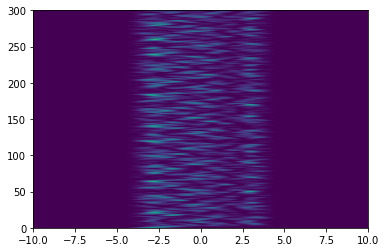

In [7]:
plt.pcolormesh(x, t, np.abs(u)**2)


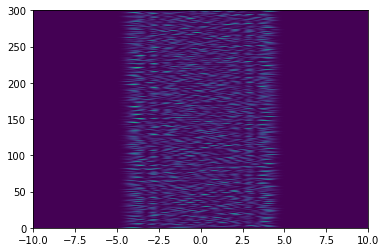

In [8]:
plt.pcolormesh(x, t, np.abs(u_dot)**2)

In [9]:
## GET REAL AND IMG PART TO USE WITH SINDY ## 

training_frac = 0.2
train_sample = int(len(t)*training_frac)

u_real = np.real(u)
u_img = np.imag(u)

u_dot_real = np.real(u_dot)
u_dot_img = np.imag(u_dot)

u_shaped = np.zeros(shape=(len(x), train_sample, 3))
u_shaped[:,:, 0]=u_real[:train_sample].T
u_shaped[:,:, 1]=u_img[:train_sample].T
u_shaped[:,:, 2]=np.tile(x,(train_sample,1)).T # add x values to pass to u and u_dot (in these way one can introduce spatial potential terms)

u_dot_shaped = np.zeros(shape=(len(x), train_sample, 2))
u_dot_shaped[:,:, 0]=u_dot_real[:train_sample].T
u_dot_shaped[:,:, 1]=u_dot_img[:train_sample].T

u_shaped.shape


(1000, 6000, 3)

In [10]:
## DEFINE CANDIDATES LIBRARY ## 

# 2nd order poly library
poly_library = ps.PolynomialLibrary(include_bias=False, degree=6) 

# PDE library
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_library = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=True, is_uniform=True, include_interaction=False)

# Tensor polynomial library with the PDE library
tensor_array = [[1, 1]]
inputs_temp = np.tile([0, 1, 2], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 3))
inputs_per_library[1,2] = 0 # only compute PDs for psi_real and psi_img
inputs_per_library[0] = [2, 2, 2] # only compute polynomial for x input feature


generalized_library = ps.GeneralizedLibrary(
    [poly_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

In [43]:
## DEFINE CLASS WRAPPER TO PERFORM CV ## 

# without this you can not pass precomputed derivatives to the fit method

from sklearn.metrics import r2_score

class SINDyCV(ps.SINDy):
    def __init__(
        self,
        optimizer=None,
        feature_library=None,
        differentiation_method=None,
        feature_names=None,
        t_default=1,
        discrete_time=False,
    ):
        super(SINDyCV, self).__init__(
            optimizer=optimizer,
            feature_library=feature_library,
            differentiation_method=differentiation_method,
            feature_names=feature_names,
            t_default=t_default,
            discrete_time=discrete_time,
        )

    def fit(self, x, y, **kwargs):
        return super(SINDyCV, self).fit(x, x_dot=y, **kwargs)
    
    def score(
        self,
        x,
        y,
        t=None,
        u=None,
        multiple_trajectories=False,
        metric=r2_score,
        **metric_kws
    ):
        return super(SINDyCV, self).score(
            x,
            x_dot=y,
            t=t,
            u=u,
            multiple_trajectories=multiple_trajectories,
            metric=metric,
            **metric_kws
        )

In [11]:
from sklearn.model_selection import ShuffleSplit

optimizer = ps.STLSQ()
model = SINDyCV(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'], t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01]
}

search = GridSearchCV(
    model,
    param_grid,
    cv=ShuffleSplit(n_splits=5, test_size=0.2),
    n_jobs=2
)
search.fit(u_shaped, y=u_dot_shaped)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

NameError: name 'SINDyCV' is not defined

In [7]:
## ADD PLOTS/TABLE RESULTS ## 

# search.cv_results_ 

In [14]:
## SET BEST THRESHOLD PARAMETER FOUND AND TRAIN USING ALL TRAINING SET ## 

# optimizer = ps.STLSQ(threshold=search.best_params_['optimizer__threshold'], verbose=True)
optimizer = ps.STLSQ(threshold=0.0001, verbose=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
model.fit(u_shaped, x_dot=u_dot_shaped, t=dt)
model.print()

print(generalized_library.get_feature_names(), "\n")

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.2970e+00 ... 7.4960e-02 ...         16 ... 1.3720e+00
         1 ... 1.1863e+00 ... 7.4965e-02 ...         16 ... 1.2612e+00
(psi_r)' = -0.679 psi_i + -0.499 psi_i_11 + -0.124 x psi_i + 0.146 x^2 psi_i + 0.014 x^3 psi_i + -0.052 x^4 psi_i + -0.001 x^5 psi_i + 0.004 x^6 psi_i
(psi_i)' = 0.679 psi_r + 0.499 psi_r_11 + 0.124 x psi_r + -0.146 x^2 psi_r + -0.014 x^3 psi_r + 0.052 x^4 psi_r + 0.001 x^5 psi_r + -0.004 x^6 psi_r
['x2', 'x2^2', 'x2^3', 'x2^4', 'x2^5', 'x2^6', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', 'x2 x1', 'x2 x0_1', 'x2 x1_1', 'x2 x0_11', 'x2 x1_11', 'x2^2 1', 'x2^2 x0', 'x2^2 x1', 'x2^2 x0_1', 'x2^2 x1_1', 'x2^2 x0_11', 'x2^2 x1_11', 'x2^3 1', 'x2^3 x0', 'x2^3 x1', 'x2^3 x0_1', 'x2^3 x1_1', 'x2^3 x0_11', 'x2^3 x1_11', 'x2^4 1', 'x2^4 x0', 'x2^4 x1', 'x2^4 x0_1', 'x2^4 x1_1', 'x2^4 x0_11', 'x2^4 x1_11', 'x2^5 1', 'x2^5 x0', 'x2^5 x1', 'x

In [15]:
psi_r_rhs=model.equations(precision=16)[0].replace('psi_i_11', 'laplace(psi_i)').replace(' ', '*').replace('*+*', '+').replace('^','**')
psi_i_rhs=model.equations(precision=16)[1].replace('psi_r_11', 'laplace(psi_r)').replace(' ', '*').replace('*+*', '+').replace('^','**')

## for complex equation other way is
# def multipleReplace(text, wordDict):
#     for key in wordDict:
#         text = text.replace(key, wordDict[key])
#     return text

reconstructed potential:
           6             5           4          3          2
0.003556 x - 0.0006862 x - 0.05181 x + 0.0143 x + 0.1462 x - 0.1237 x - 0.679
x_max [-1.41382059  1.11465338]
x_min [-2.82816434  2.82821941  0.45992048]
          6             5           4           3          2
0.003565 x - 0.0006882 x - 0.05195 x + 0.01434 x + 0.1467 x - 0.124 x - 0.6807


array([0.24090557, 0.28646703, 0.2689575 , 0.30468743, 0.33890098,
       0.2774701 , 0.24665426])

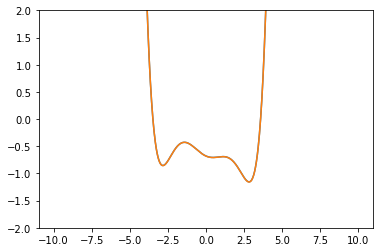

In [16]:
## COMPUTE RECONSTRUCTED POTENTIAL ##

feat_name = generalized_library.get_feature_names()
r_param = [feat_name.index('x1'), feat_name.index('x2 x1'), feat_name.index('x2^2 x1'), feat_name.index('x2^3 x1'), feat_name.index('x2^4 x1'), feat_name.index('x2^5 x1'), feat_name.index('x2^6 x1')]
i_param = [feat_name.index('x0'), feat_name.index('x2 x0'), feat_name.index('x2^2 x0'), feat_name.index('x2^3 x0'), feat_name.index('x2^4 x0'), feat_name.index('x2^5 x0'), feat_name.index('x2^6 x0')]

V_r = model.coefficients()[0][r_param]
V_i = model.coefficients()[1][i_param]

V_coeff = (V_r - V_i)/2
V_coeff = V_coeff[::-1]
V_sim = np.poly1d(V_coeff)
plt.plot(x, V_sim(x))

print('reconstructed potential:\n', V_sim)

x_crit = V_sim.deriv().r
x_min = x_crit[V_sim.deriv(2)(x_crit)>0]
x_max = x_crit[V_sim.deriv(2)(x_crit)<0]

print('x_max', x_max)
print('x_min', x_min)

## TRUE POTENTIAL ## 

V_true_coeff = np.array([-0.76296297, -0.08380526,  0.2074074 ,  0.02095131, -0.06296296,
       -0.00130946,  0.00416667]) # symmetric 

V_true_coeff = np.array([-0.68068553, -0.12404459,  0.14671844,  0.01434461, -0.05194725,
       -0.00068821,  0.00356478]) 

V_true_coeff = V_true_coeff[::-1]

V_true = np.poly1d(V_true_coeff)
print(V_true)

plt.plot(x, V_true(x))
plt.ylim(-2,2)

100*np.abs(V_coeff - V_true_coeff)/np.abs(V_true_coeff)


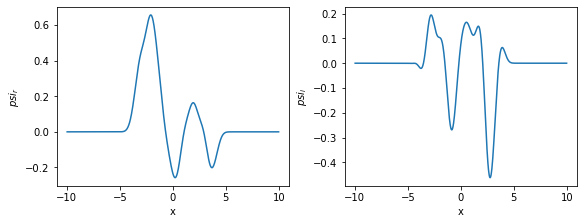

In [15]:
## FITTED MODEL SIMULATION ## 

# TO DO: GENERALIZE EQUATION WRITING FROM MODEL RESULT

# uxx_re = model.coefficients()[0,8]
# uxx_im = model.coefficients()[1,7]
# x2psi_re = model.coefficients()[0,18]
# x2psi_im = model.coefficients()[1,17]

# eq = pde.PDE({'psi_r':'{}*laplace(psi_i)+{}*x*x*psi_i'.format(uxx_re, x2psi_re), 
#               'psi_i':'{}*laplace(psi_r)+{}*x*x*psi_r'.format(uxx_im, x2psi_im)})

eq=pde.PDE({'psi_r':psi_r_rhs, 
           'psi_i':psi_i_rhs})


## DEFINE SPATIAL GRID ##

Nx = len(x) # number of spatial points
x_left = x[0]
x_right = x[-1]

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

## DEFINE INITIAL STATE FOR SIMULATION (use last u entry) ##

initial_state_r = pde.ScalarField(grid, u_real[train_sample], label= '$psi_r$')
initial_state_i = pde.ScalarField(grid, u_img[train_sample], label = '$psi_i$')

initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

initial_state.plot()


In [16]:
## PERFORM SIMULATION ##

# define storage 
storage = pde.MemoryStorage() # for movie and control plots

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = t[-1]-t[train_sample]
dt_sim = 1e-5

dt_save = 0.01


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_save)])
_ = controller.run(initial_state, dt=dt_sim)

  0%|          | 0/239.9999999998788 [00:00<?, ?it/s]

In [17]:
## COMBINE REAL AND IMAGINARY PART ## 

data_sim = np.array([storage.data[i][0]+1j*storage.data[i][1] for i in range(len(storage))])
storage_sim = pde.MemoryStorage(times=t[train_sample]+np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$psi_sim$', dtype=np.complex128))


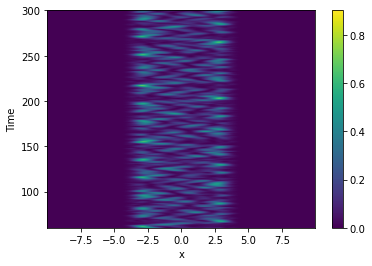

In [18]:
## PLOT SIMULATION ##

pde.plot_kymograph(storage_sim, scalar='norm_squared')

In [19]:
from tqdm.notebook import tqdm

def my_pbar(curr_frame, tot_frame):
    pbar.update(100*curr_frame/tot_frame)

In [22]:
## GENERATE MOVIE ##

# set backend to nbagg for better movie quality
%matplotlib nbagg

sindy_sim = storage_sim.data
times = storage_sim.times

# use only a part of the points for movie
frac = len(times)/1000

fig,ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel(r"$|\psi|^2$")
title = ax.set_title('', y=1.05)
line1, = ax.plot(x, np.abs(sindy_sim[0])**2, "k--", label="SINDy")
line2, = ax.plot(x, np.abs(u[train_sample])**2, "b", label="original")
 
plt.legend(loc=1, fontsize=8, fancybox=False)


def init():
    return line1, line2


def animate(i):
    ax.set_facecolor('white')
    line1.set_data(x, np.abs(sindy_sim[i])**2)
    line2.set_data(x, np.abs(u[i+train_sample])**2)
    title.set_text('Time = {0:1.3f}'.format(times[i]))
    return line1, line2


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1, blit=True,frames=np.arange(0,len(times),int(frac)))

writer = animation.FFMpegWriter(fps=30, bitrate=-1)


print("Generating animation ...")
pbar = tqdm(total=(len(times)-1)*50/frac)
anim.save(f'./Data/Simulation_video/catalyzer_x4_{x4:.3f}_scale_{scale:.3f}_mu_{mu:.1f}.mov', writer=writer, dpi=150, progress_callback=my_pbar)
pbar.close()
print("Done")

# reset backend to inline
%matplotlib inline


<IPython.core.display.Javascript object>

Generating animation ...


  0%|          | 0/49997.916753468606 [00:00<?, ?it/s]

Done


In [23]:
## VISUALIZE MOVIE ##

Video(f'./Data/Simulation_video/catalyzer_x4_{x4:.3f}_scale_{scale:.3f}_mu_{mu:.1f}.mov')

Probability conserved: False


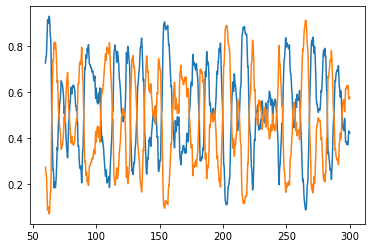

In [24]:
sindy_sim = np.array(sindy_sim)
# compute psi_squared
prob = np.abs(sindy_sim**2)

# compute probability of finding particle on the left or right of the maximum
left_prob = prob[:, x<=0].sum(axis=1)*dx
right_prob = prob[:, x>0].sum(axis=1)*dx

# check if total prob is conserved
print('Probability conserved:', np.allclose(np.ones_like(left_prob), left_prob+right_prob))

plt.plot(times, left_prob)
plt.plot(times, right_prob)

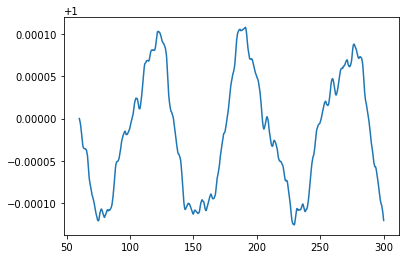

In [25]:
plt.plot(times, prob.sum(axis=1)*dx)

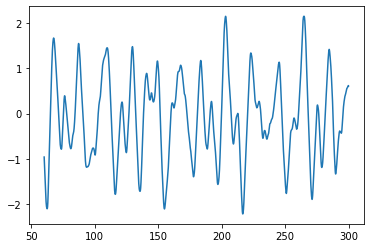

In [26]:
avg_x = np.sum(prob*x, axis=1)*dx
plt.plot(times, avg_x)